In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

# Modelo: Árbol de Decisión

https://scikit-learn.org/stable/modules/tree.html

En este notebook entrenaremos el modelo de **Arbol de Decisión**, un primer modelo simple que se caracteriza por tener un criterio de decisión similar al de un humano. El objetivo es ir formando un arbol en diferentes nodos repartiendo las instancias segun los feature de nuestro dataset. El hecho de escoger el mejor feature para repartir las instancias se realizaba bajo dos diferentes criterios: Impureza de Gini ó Entropía.

En el entrenamiento de este modelo, se pasará a tener en cuenta los siguientes hiperparametros:

* criterion: es aquel criterio que comentamos de Gini o de Entropía. Probaremos los 2 en la busqueda del mejor hiperparametro.
* min_samples_leaf: corresponde a la canitdad de instancias minimas que puede almacenar un nodo hoja.
* max_depth: la profondida maxima que puede agarrar nuestro arbol formado

Los ultimos 2 hiperparaemtros son demasiados importantes. 

No dejaremos que nuestro algoritmo particione demasiado, pues si nuestro arbol tiene muchisima profundida corresmos el riesgo de tener muchas ramas de nuestro arbol, por ende nos podria ocurrir el inconveniente de memorizar demasiado nuestro dataset logrando tener overfitting. En cambio, si mantenemos una maxima profundida muy chica de 1 o 2, corresmo el riesgo de tener un modelo demasiado general, es decir el sinonimo de alto sesgo: solo nos centraremos en muy pocos atributos, ignorando muchisimos otros. 

En conclusión, nos aparece el inconveniente trade-off Sesgo vs Varianza.

Para esto, limitaremos la profundida maxima de 3 a 8 en todos los casos, como tambien los min samples de ???? a ?????.

# Importación de librerias y datasets

Segun nuestro preprocessing.py desarollado e investigado, importaremos inicialmente la primera función necesaria para trabajar:

In [2]:
from preprocessing import obtener_datasets

Obtendremos nuestro 2 datasets.
* df: el que usaremos para entrenar
* df_for_prediction: el que usaremos a final de todo como *holdout* para predecir. 

In [3]:
df, df_for_prediction = obtener_datasets()

Además para varios preproceasmientos que probaremos usaremos esta funcion que nos calcula el AUC-ROC para test y train, como tambien nos imprime los mejores hiperparametros elegidos.

# Primer Preprocesamiento: conversion_numerica()

Como primer preprocesameitno simple primero realizaremos una preparación acorde al Análisis Exploratorio realizado en la parte 1 de este trabajo práctico, además al llamar a esta función nos devuelve el el set de entrenameinto 'X' como el set de validación 'y' de nuestra variable target a predecir (alto_valor_adquisitivo). Esta función está dentro de nuestro preproecssing.py, la importamos y aplicamos.

In [4]:
from preprocessing import aplicar_preparacion

In [5]:
X_df, y_df = aplicar_preparacion(df)
X_df.shape

(32561, 11)

Además haremos una conversión numérica debido a que en sklearn los arboles no trabajan con variables categoricas. A las categoricas con nocion de orden se le asigna su numero correpsondiente con OrdinalEncoder y las de sin orden se convierte en nuevas feature binarias con OneHotEncding. Este prepreorcesamiento lo aplicamos con la función de 'conversion_numerica()' importada

In [6]:
from preprocessing import conversion_numerica

In [7]:
X_df_numerico = conversion_numerica(X_df) 
X_df_numerico.shape

Aplicando 'conversion_numerica' en las variables categóricas.


(32561, 40)

Quedandonos 40 features de las 11 posibles que teniamos.

Dividimos nuestro dataset en train y test antes de empezar a entrenar nuestro árbol de decisión el cual usaremos train para entrenar y luego con test para validar nuestro entrenamiento.

En esta división la tenemos en cuenta según el **straify**: es decir, estamos indicandole de dividr el dataset en proporciones iguales en cuanto a la clase a predecir. 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df, random_state=10, test_size=0.20, stratify=y_df)

Utilizaremos GridSearchCV para la busqueda de hiperparametros, además buscando mejorar la metrica solciita de **auc-roc**. También, con GridSearchCV nos permite realizar cross-validation, por ende también lo aplicaremos pero de manera **Stratified** por las mismas razones mencioandas en el split de train y test.

Los hiperparametros por el que buscará GridSearchCV serán los siguientes:

In [9]:
params = {
    'max_depth': np.arange(3, 8),
    'min_samples_leaf': np.arange(50, 100, 1),
    "criterion": ["gini", "entropy"],
}

Definimos el modelo clasificador (clf) del Árbol de Decisión con el StratifiedKFold para cross-validation mencionado. Esto esto lo meteremos en la "licuadora" de GridSearchCV:

In [10]:
clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True)

Entrenaremos y predizcamos con el X_test con el que dividimos anteriormente.

In [11]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 1548 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.4min finished


In [12]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)

AUC-ROC score sobre test:  0.9013640478941830
AUC-ROC score sobre train:  0.9076413130904566
Accuracy sobre test:  0.8562874251497006
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 50}


0.9013 de AUC-ROC sobre el set de test, nada mal. Veamos diferentes métricas más:

In [13]:
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))

              precision    recall  f1-score   support

  Bajo valor       0.87      0.96      0.91      4945
  Alto valor       0.79      0.54      0.65      1568

    accuracy                           0.86      6513
   macro avg       0.83      0.75      0.78      6513
weighted avg       0.85      0.86      0.85      6513



Vemos una sutileza con al precisión de alto valor. Esto además lo podemos comprobar con la matriz de confusión que construimos como función adicional en nuestro preprocessing.py, primero la improtamos y luego graficamos

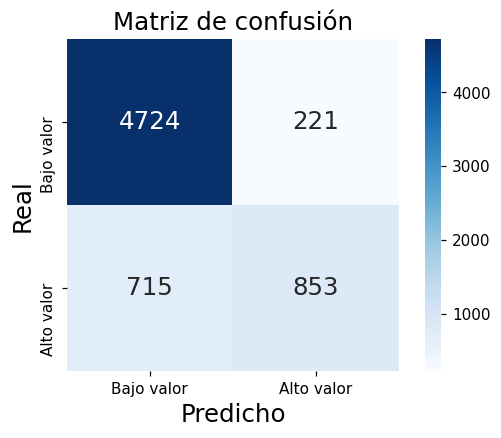

In [14]:
from preprocessing import graficar_matriz_confusion
graficar_matriz_confusion(y_test, y_pred)

Es decir, le cuesta predecir a los alto valor. Esto se nota con la baja precisión del modelo y en la diagonal de la matriz de confusión

Pero a grandes rasgos, tenemos un buen modelo que no overfittea y que no es ni tan general, mostremos su curva ROC mediante una función auxiliar tambien disponible en nuestro preprocessing.py

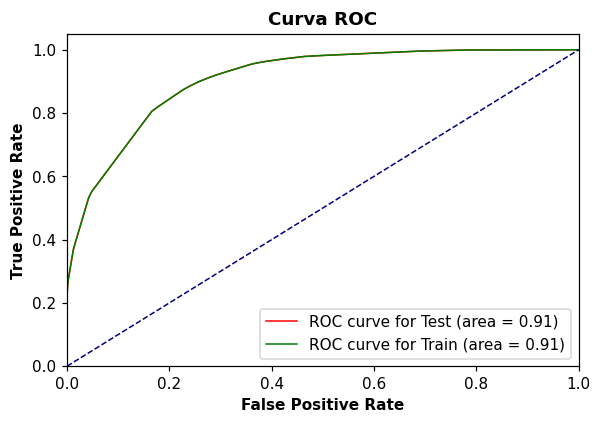

In [15]:
from preprocessing import plot_roc_curves
plot_roc_curves(clf, X_train, y_train, X_train, y_train)

Logrando con esto un muy buen AUC-ROC pero peor precisión para los de alto valor. Veamos si con otros preprocesamientos esto puede ir mejorando aunque nos enfocaremos en seguir obteniendo el mejor AUC-ROC. 

La forma de entrenar, predecir y graficar resultados para los proximos preprocesamietnos será de la misma forma descripta en este primer preprocesamiento, no daremos tantos detalles tal como hicimos en este primer preprocesameinto.

# Segundo Preprocesamiento: get_dataframe_polynomial()

Para este caso, buscaremos realizar una expansión del dataset mediante PolynomialFeatures. Ésto solo se aplicará para las 4 columnas numéricas que tenemos en nuestro dataset inicial:

In [16]:
df.describe()

,anios_estudiados,edad,suma_declarada_bolsa_argentina,horas_trabajo_registradas
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456
std,2.664488,13.640433,7408.986951,12.347429
min,1.000000,17.000000,-4356.000000,1.000000
25%,13.000000,28.000000,0.000000,40.000000
50%,14.000000,37.000000,0.000000,40.000000
75%,16.000000,48.000000,0.000000,45.000000
max,20.000000,90.000000,99999.000000,99.000000


Nuestra funcion desarrollada en preprocessing.py aplica solamente a estas 4 features dicha expansión. Ademas esta función le podemos decir qué grado aplicar para buscar esa expansión como tambien un booleano indicandole si se permite realizar potencias entre features. Importemos y apliquemos dicho preprocesado.

In [17]:
from preprocessing import get_dataframe_polynomial
X_df_numerico_poly = get_dataframe_polynomial(X_df_numerico, 2, True)
X_df_numerico_poly.shape

Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 46 features...


(32561, 46)

Antes de empezar a entrenar, aplicaremos este preproecesamietno con las 2 variantes: el booleano en true y false. Defindamos una funcion que repita el proceso meniconado en el primer preprocesamietno de dividir_train_test/entrenar/predecir/graficar. 
Por el momento solo grafiacremos la matriz de confusión, los mejores hiperparametros y el AUC-ROC.

In [18]:
def auc_roc_for(X, y):
    XX_train, XX_test, yy_train, yy_test = train_test_split(X, y, random_state=10, test_size=0.20, stratify=y_df)

    params = {
        'max_depth': np.arange(3, 8),
        'min_samples_leaf': np.arange(20, 50, 1),
        "criterion": ["gini", "entropy"],
    }
    cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(XX_train, yy_train)
    clf_r = tree.DecisionTreeClassifier(random_state=10)
    clf = GridSearchCV(clf_r, params, scoring='roc_auc', cv=cv_e, n_jobs = -1)

    clf.fit(XX_train, yy_train)
    yy_pred = clf.predict(XX_test)

    print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(yy_test, clf.predict_proba(XX_test)[:, 1]))
    print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(yy_train, clf.predict_proba(XX_train)[:, 1]))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)
    graficar_matriz_confusion(yy_test, yy_pred)

* Con PolynomialFeatures(2, interaction_only = True)

Ya habiamos llamado a la función, pero hagamoslo de nuevo:

In [19]:
X_df_numerico_poly = get_dataframe_polynomial(X_df_numerico, 2, True)
X_df_numerico_poly.shape

Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 46 features...


(32561, 46)

AUC-ROC score sobre test:  0.9015440895771858
AUC-ROC score sobre train:  0.9107209454038468
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 20}


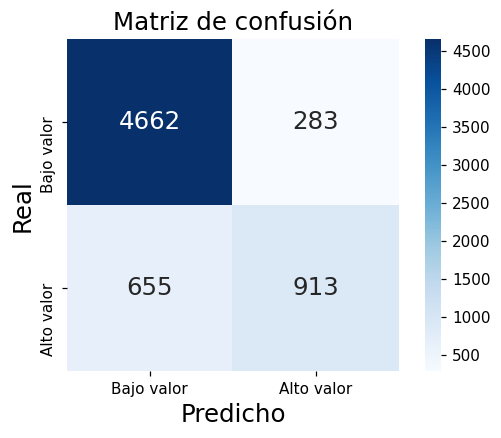

In [20]:
auc_roc_for(X_df_numerico_poly, y_df)

Vemos que empeoró el AUC-ROC, pero mejoró la precisión sobre lo de alto valor. Veamos ahora con el booleano para las potencias en false:

* Con PolynomialFeatures(2, interaction_only = False)

In [21]:
X_df_numerico_poly = get_dataframe_polynomial(X_df_numerico, 2, False)
X_df_numerico_poly.shape

Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 50 features...


(32561, 50)

AUC-ROC score sobre test:  0.9006571650399291
AUC-ROC score sobre train:  0.9120560796446070
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 25}


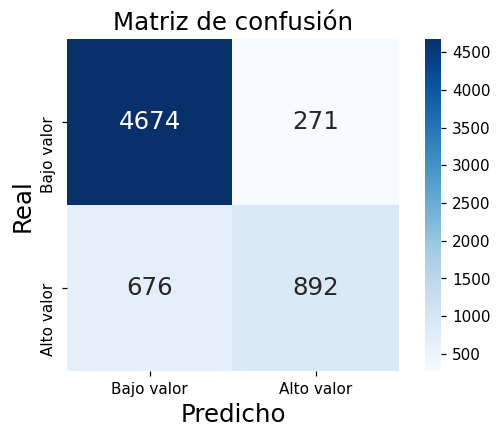

In [22]:
auc_roc_for(X_df_numerico_poly, y_df)

Exploremos con otros preprocesamientos para ver si mejora esto.

# Tercer Preprocesamiento: get_dataframe_scaled()

Para este tercer preprocesamiento vamos a realizar un escalado de los datos con nuestra función 'get_dataframe_scaled()' el cual requiere que le pasemos un escalador y el dataset a escalar. La misma nos devolverá el dataset escalado.

In [23]:
from preprocessing import get_dataframe_scaled
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

## Normalizer()

Empezemos con un normalizador que deja a nuestras variables entre 0 y 1. Lo cual esto podria dar signifciatviamente distinto a lo que tenemos esperado

In [24]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df) 

X_df_numerico_normalization = get_dataframe_scaled(X_df_numerico, Normalizer())

Aplicando 'conversion_numerica' en las variables categóricas.


In [25]:
X_df_numerico_normalization.describe()

,anios_estudiados,edad,educacion_alcanzada,suma_declarada_bolsa_argentina,horas_trabajo_registradas,genero_mujer,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado_a,...,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.219231,0.559374,0.065264,0.036645,0.599344,0.005871,0.006076,0.000013,0.000206,0.000517,...,0.000006,0.000007,0.000510,0.013434,0.001629,0.000149,0.003574,0.000567,0.004050,0.001724
std,0.109033,0.246334,0.032977,0.358411,0.265739,0.009473,0.007996,0.000507,0.001933,0.003035,...,0.000437,0.000387,0.003127,0.009077,0.005438,0.001751,0.008993,0.003473,0.007665,0.005340
min,0.000024,0.000210,0.000000,-0.999930,0.000088,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.180765,0.482559,0.053558,0.000000,0.550952,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.232593,0.610776,0.069633,0.000000,0.687107,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.015449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.277793,0.723496,0.083992,0.000000,0.780340,0.014797,0.014711,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.018781,0.000000,0.000000,0.000000,0.000000,0.000095,0.000000
max,0.593732,0.995929,0.186862,1.000000,0.978616,0.048912,0.040032,0.030471,0.038236,0.033113,...,0.042409,0.039193,0.040032,0.049088,0.046625,0.041959,0.048912,0.047836,0.049088,0.042718


Dividamos y entrenemos:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico_normalization, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(3, 8),
    'min_samples_leaf': np.arange(50, 100, 1),
    "criterion": ["gini", "entropy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.7min finished


AUC-ROC score sobre test:  0.8858390638864240
AUC-ROC score sobre train:  0.8927718597331731
Accuracy sobre test:  0.8495317058191310
Los mejores hiperpametros elegidos:  {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 90}


Vemos que empeoró demasiado el AUC-ROC. Veamos si al precisión se levantó con esto:

In [27]:
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))

              precision    recall  f1-score   support

  Bajo valor       0.96      0.86      0.91      5485
  Alto valor       0.52      0.79      0.62      1028

    accuracy                           0.85      6513
   macro avg       0.74      0.82      0.76      6513
weighted avg       0.89      0.85      0.86      6513



Se mantuvo igual. Pasemos con otro preprocesamiento con otro escalado:

## StandardScaler()

In [28]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df) 

X_df_numerico_standar = get_dataframe_scaled(X_df_numerico, StandardScaler())

Aplicando 'conversion_numerica' en las variables categóricas.


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico_standar, y_df, random_state=10, test_size=0.20, stratify=y_df)

params = {
    'max_depth': np.arange(3, 8),
    'min_samples_leaf': np.arange(50, 100, 1),
    "criterion": ["gini", "entropy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
cv_e = StratifiedKFold(n_splits=5, random_state=10, shuffle=True).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv_e, n_jobs = -1, verbose=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:   24.7s


AUC-ROC score sobre test:  0.9013640478941830
AUC-ROC score sobre train:  0.9076413130904566
Accuracy sobre test:  0.8562874251497006
Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 50}


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   38.3s finished


Nos dió exactamente igual al primer preprocesamiento. Por ende con una estandarización de los datos podemos concluir que no afecta el calculo del Gini o la Entropía en el arbol de decisión, sí lo es el caso de una normalización que los lleva entre 0 y 1 a los datos obligadamente.

# El mejor preprocesamiento: get_dataframe_polynomial()

Habiamos visto que aplicar un polynomial de grado 2 con las potencias en true mejoraba nuestra metrica de AUC-ROC unos muy pocos puntos y un poco la precisión. Solo detallamos la matriz de confusión y el auc-roc score. Vaemos todas las métricas en sí que nos dió este modelo con la siguiente confugración de hiperparametros:

    Los mejores hiperpametros elegidos:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 20}

In [30]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df) 

X_df_numerico_poly = get_dataframe_polynomial(X_df_numerico, 2, True)
X_df_numerico_poly.shape

Aplicando 'conversion_numerica' en las variables categóricas.
Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 46 features...


(32561, 46)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico_poly, y_df, random_state=10, test_size=0.20, stratify=y_df)

clf = tree.DecisionTreeClassifier(random_state=10, criterion = 'gini', max_depth = 7, min_samples_leaf = 20)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))


AUC-ROC score sobre test:  0.9015440895771858
AUC-ROC score sobre train:  0.9107209454038468
Accuracy sobre test:  0.8559803469983110


In [32]:
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))

              precision    recall  f1-score   support

  Bajo valor       0.94      0.88      0.91      5317
  Alto valor       0.58      0.76      0.66      1196

    accuracy                           0.86      6513
   macro avg       0.76      0.82      0.78      6513
weighted avg       0.88      0.86      0.86      6513



Lo cual se puede ver esa mejora en la precisión de alto valor a comparación del primer preprocesamiento realizado.

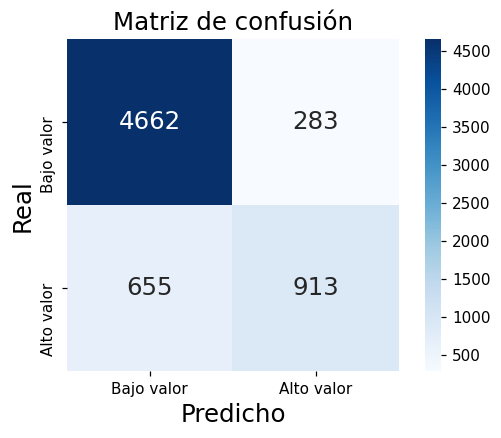

In [33]:
graficar_matriz_confusion(y_test, y_pred)

Clarametne esto se ve reflejado en el grafico de matriz de confusión. No es la mejor precisión posible puesto que tambien nos centramos en buscar mejorar y encontrar los mejores hiperparametros para la mejora de 'auc-roc score'.

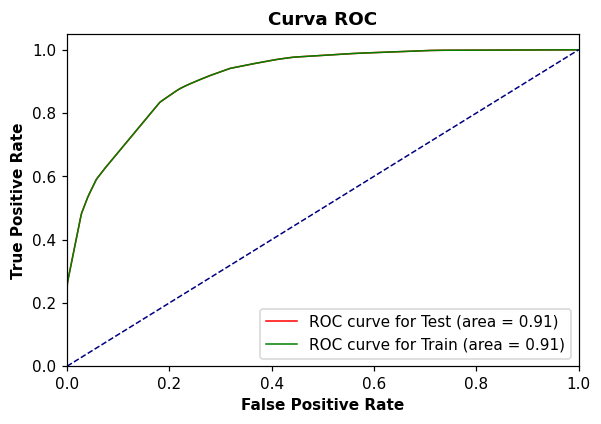

In [34]:
plot_roc_curves(clf, X_train, y_train, X_train, y_train)

Además obtuvimos un buen modelo que no esté ni tan sesgado ni ni overtifiado, pues eso se nota en las brechas de curvas de Test y Train: son practicamente iguales. Por lo que esperamos que para predecir holdout tenga buen score.

# Predicciones holdout

Utilizar este mejor preprocesado del item #6 para predecir el holdout!!!